In [1]:
#Load the Data
import pandas as pd

# Load the datasets
customers = pd.read_csv("H:/My Drive/Zeotap Assignment DS/Customers(1).csv")
products = pd.read_csv("H:/My Drive/Zeotap Assignment DS/Products.csv")
transactions = pd.read_csv("H:/My Drive/Zeotap Assignment DS/Transactions.csv")

# Display the first few rows of each dataset
print("Customers Data:\n", customers.head())
print("Products Data:\n", products.head())
print("Transactions Data:\n", transactions.head())

Customers Data:
   CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
Products Data:
   ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
Transactions Data:
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127

In [2]:
#Featuring the Data
# Merge customer and transaction data
customer_transactions = customers.merge(transactions, on='CustomerID')

# Create features for clustering
customer_features = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],  # Total spending and average transaction value
    'Quantity': 'sum',              # Total quantity purchased
    'TransactionID': 'count'        # Total number of transactions
}).reset_index()

# Flatten the multi-index columns
customer_features.columns = ['CustomerID', 'TotalSpending', 'AvgTransactionValue', 'TotalQuantity', 'NumTransactions']

# Merge with customer profile data
customer_features = customer_features.merge(customers, on='CustomerID')

# Display the first few rows of the new features
print(customer_features.head())
#save the Customer_feature file 
# Save customer_features to a CSV file
customer_features.to_csv("customer_features.csv", index=False)


  CustomerID  TotalSpending  AvgTransactionValue  TotalQuantity  \
0      C0001        3354.52              670.904             12   
1      C0002        1862.74              465.685             10   
2      C0003        2725.38              681.345             14   
3      C0004        5354.88              669.360             23   
4      C0005        2034.24              678.080              7   

   NumTransactions        CustomerName         Region  SignupDate  
0                5    Lawrence Carroll  South America  2022-07-10  
1                4      Elizabeth Lutz           Asia  2022-02-13  
2                4      Michael Rivera  South America  2024-03-07  
3                8  Kathleen Rodriguez  South America  2022-10-09  
4                3         Laura Weber           Asia  2022-08-15  


In [3]:
#Normalize the data
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features = customer_features[['TotalSpending', 'AvgTransactionValue', 'TotalQuantity', 'NumTransactions']]

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Display the first few rows of the scaled features
print(features_scaled[:5])

C:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[[-0.06170143 -0.07026341 -0.12203296 -0.01145819]
 [-0.87774353 -0.93493297 -0.44800021 -0.46749414]
 [-0.40585722 -0.02627131  0.20393428 -0.46749414]
 [ 1.03254704 -0.0767689   1.67078689  1.35664965]
 [-0.78392861 -0.04002806 -0.93695108 -0.92353008]]


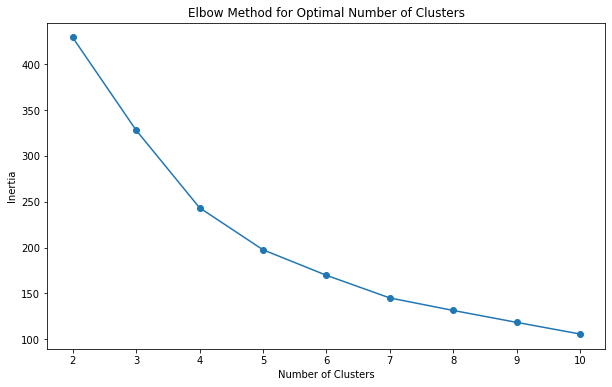

In [4]:
# Determine the number of cluster
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [5]:
#perform K-means clustering with K=4

kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(features_scaled)

# Display the first few rows with cluster labels
print(customer_features.head())

  CustomerID  TotalSpending  AvgTransactionValue  TotalQuantity  \
0      C0001        3354.52              670.904             12   
1      C0002        1862.74              465.685             10   
2      C0003        2725.38              681.345             14   
3      C0004        5354.88              669.360             23   
4      C0005        2034.24              678.080              7   

   NumTransactions        CustomerName         Region  SignupDate  Cluster  
0                5    Lawrence Carroll  South America  2022-07-10        3  
1                4      Elizabeth Lutz           Asia  2022-02-13        0  
2                4      Michael Rivera  South America  2024-03-07        3  
3                8  Kathleen Rodriguez  South America  2022-10-09        1  
4                3         Laura Weber           Asia  2022-08-15        0  


In [6]:
#calculate Cluster with Devis-Boudlin-Index
from sklearn.metrics import davies_bouldin_score

# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(features_scaled, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.9438573778754462


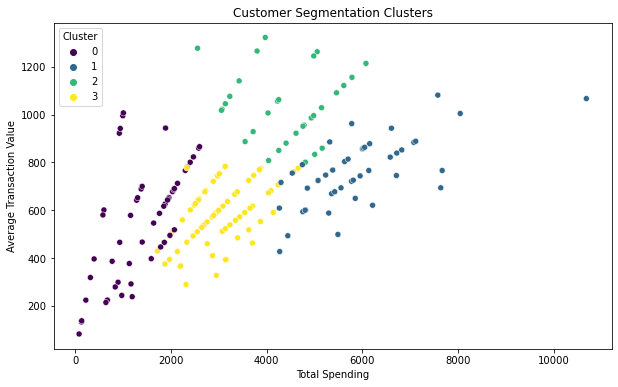

In [7]:
import seaborn as sns

# Visualize clusters using two features (e.g., TotalSpending and AvgTransactionValue)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalSpending', y='AvgTransactionValue', hue='Cluster', data=customer_features, palette='viridis')
plt.title('Customer Segmentation Clusters')
plt.xlabel('Total Spending')
plt.ylabel('Average Transaction Value')
plt.show()

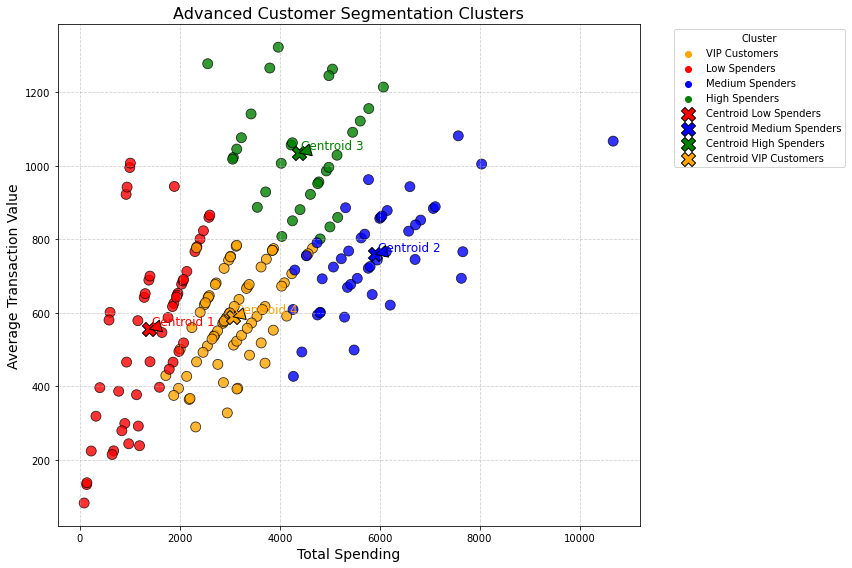

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color palette for the clusters (fix by using labels as keys)
cluster_colors = {
    'Low Spenders': 'red',
    'Medium Spenders': 'blue',
    'High Spenders': 'green',
    'VIP Customers': 'orange'
}

# Map cluster numbers to meaningful labels
cluster_labels = {
    0: 'Low Spenders',
    1: 'Medium Spenders',
    2: 'High Spenders',
    3: 'VIP Customers'
}

# Add a new column for cluster labels
customer_features['ClusterLabel'] = customer_features['Cluster'].map(cluster_labels)

# Advanced visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='TotalSpending',
    y='AvgTransactionValue',
    hue='ClusterLabel',
    palette=cluster_colors,  # Now the keys match the categorical labels
    data=customer_features,
    s=100,  # Size of the points
    edgecolor='black',
    alpha=0.8
)

# Add cluster centroids to the plot
centroids = kmeans.cluster_centers_
centroids_scaled = scaler.inverse_transform(centroids)  # Reverse scaling to original values

for i, centroid in enumerate(centroids_scaled):
    plt.scatter(
        centroid[0],  # TotalSpending
        centroid[1],  # AvgTransactionValue
        color=cluster_colors[cluster_labels[i]],  # Use updated cluster_colors
        s=200,  # Size of the centroid
        marker='X',
        edgecolor='black',
        label=f'Centroid {cluster_labels[i]}'
    )

# Add annotations for cluster centroids
for i, centroid in enumerate(centroids_scaled):
    plt.annotate(
        f'Centroid {i+1}',
        xy=(centroid[0], centroid[1]),
        xytext=(centroid[0] + 50, centroid[1] + 10),
        fontsize=12,
        color=cluster_colors[cluster_labels[i]],
        arrowprops=dict(facecolor=cluster_colors[cluster_labels[i]], shrink=0.05)
    )

# Labels and title
plt.title('Advanced Customer Segmentation Clusters', fontsize=16)
plt.xlabel('Total Spending', fontsize=14)
plt.ylabel('Average Transaction Value', fontsize=14)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

# Save the advanced visualization as an image
plt.savefig('Advanced_Clustering_Visualization.png', bbox_inches='tight', dpi=300)

AttributeError: 'Figure' object has no attribute 'update_layout'

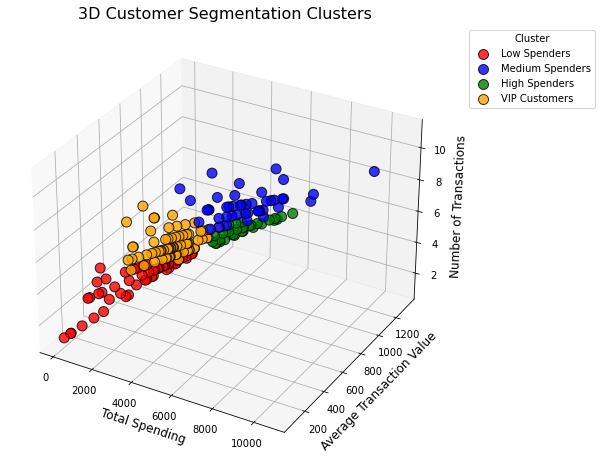

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette with labels as keys (Fix 1)
cluster_colors = {
    'Low Spenders': 'red',
    'Medium Spenders': 'blue',
    'High Spenders': 'green',
    'VIP Customers': 'orange'
}

# Map cluster numbers to meaningful labels
cluster_labels = {
    0: 'Low Spenders',
    1: 'Medium Spenders',
    2: 'High Spenders',
    3: 'VIP Customers'
}

# Add a new column for cluster labels
customer_features['ClusterLabel'] = customer_features['Cluster'].map(cluster_labels)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster in 3D
for label, color in cluster_colors.items():  # Fix 2: Iterate using labels, not numbers
    cluster_data = customer_features[customer_features['ClusterLabel'] == label]
    ax.scatter(
        cluster_data['TotalSpending'],
        cluster_data['AvgTransactionValue'],
        cluster_data['NumTransactions'],
        color=color,
        label=label,
        s=100,
        edgecolor='black',
        alpha=0.8
    )

# Add labels and title
ax.set_xlabel('Total Spending', fontsize=12)
ax.set_ylabel('Average Transaction Value', fontsize=12)
ax.set_zlabel('Number of Transactions', fontsize=12)
ax.set_title('3D Customer Segmentation Clusters', fontsize=16)

# Add legend
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
# Show the plot
plt.show()


In [1]:
# Import necessary libraries
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd
from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output

# Load your dataset
customer_features = pd.read_csv("H:/My Drive/Zeotap Assignment DS/customer_features.csv")

# Perform clustering if necessary
if 'ClusterLabel' not in customer_features.columns:
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=4)
    customer_features['ClusterLabel'] = kmeans.fit_predict(customer_features[['TotalSpending', 'AvgTransactionValue', 'NumTransactions']])

# Define cluster colors
cluster_colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange'
}

# Initialize the Dash app
app = JupyterDash(__name__)

# Define the layout of the app with a dropdown for selecting clusters
app.layout = html.Div([
    html.H1("Customer Segmentation Dashboard"),
    
    # Dropdown for selecting cluster
    dcc.Dropdown(
        id='cluster-dropdown',
        options=[{'label': f'Cluster {i}', 'value': i} for i in range(4)],
        value=0,  # Default cluster value
        style={'width': '50%'}
    ),
    
    # Graph for displaying the 3D plot
    dcc.Graph(id='cluster-3d-plot')
])

# Define the callback function to update the plot based on dropdown value
@app.callback(
    Output('cluster-3d-plot', 'figure'),
    [Input('cluster-dropdown', 'value')]
)
def update_graph(cluster_id):
    # Filter data based on selected cluster
    filtered_data = customer_features[customer_features['ClusterLabel'] == cluster_id]
    
    # Create the updated 3D scatter plot for the selected cluster
    fig = px.scatter_3d(
        filtered_data,
        x='TotalSpending',
        y='AvgTransactionValue',
        z='NumTransactions',
        color='ClusterLabel',
        color_discrete_map=cluster_colors,
        hover_name='CustomerID',
        title=f'3D Segmentation - Cluster {cluster_id}'
    )
    return fig

# Run the app inside the Jupyter notebook
app.run_server(mode="inline")


C:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Anaconda\lib\site-packages\dash\dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.

